# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents the numerical solution for the 1D elastic wave equation

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t u(x,t) \ = \ c^2 \partial_x^2 u(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$.

In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

# Import pickle for save and load the variables
import pickle

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

In [63]:
# Load the variables
with open('4_se_data.pkl', 'rb') as f:
    t_grid, x_grid, u_grid = pickle.load(f)
    
x_grid=np.array(x_grid)
t_grid=np.array(t_grid)
u_grid=np.array(u_grid)    

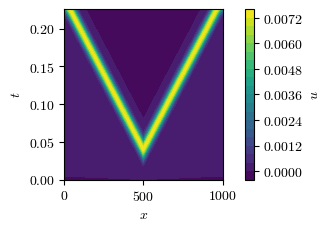

In [64]:
# Create a figure for the plot
# Set the figure size in inches
fig = plt.figure(figsize=(3.2, 2.2))

# Plot the u values as a function of t and x using a filled contour plot
# The 'levels' parameter determines the number and positions of the contour lines / regions
plt.contourf(x_grid, t_grid, u_grid, levels=20)

# Add a colorbar to the plot with the label 'u'
# The colorbar provides a visual guide to the range of values in the plot
plt.colorbar(label='$u$')

# Label the x and y axes
plt.xlabel('$x$')  # Label for the x-axis
plt.ylabel('$t$')  # Label for the y-axis

# Display the plot
plt.show()

In this simulation, we utilize a Gaussian function as the source term, which is typically characterized by its bell-shaped curve and defined by the following formula:

$$
s(x,t) = \text{{factor}} \cdot (t - t0) \cdot \exp(-a \cdot (t - t0)^2)
$$


In [124]:
np.shape(x_grid_array)

(626,)

In [125]:
# Convert t_grid to a numpy array and select the first column
t_grid_array = np.array(t_grid)[:,0]
x_grid_array = np.array(x_grid)[0,:]

# Calculate dt as the difference between the first two elements in t_grid_array
dt = np.diff(t_grid_array)[0]

# Calculate nt as the length of the differences in t_grid_array
nt = len(t_grid_array)

# Calculate nt as the length of the differences in t_grid_array
nx = len(x_grid_array)

# Define the factor for the source term
factor = 10e-4

# Create a time array from 0 to nt*dt with nt points
t = np.linspace(0 * dt, nt * dt, nt)

# Define the dominant frequency of the source (Hz)
f0 = 25.

# Calculate the source time shift
t0 = 1.0 / f0

# Calculate the constant 'a' for the Gaussian source term
a = np.pi*np.pi*f0*f0

# Calculate the Gaussian source term
src = factor * 2 * (4 * f0) * np.exp(-1.0 * (4 * f0) ** 2 * (t - t0) ** 2)

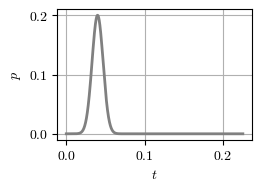

In [126]:
# Create a figure for the plot
fig, ax = plt.subplots(figsize=(2.5, 1.8))

# Plot the function
ax.plot(t,src, color='gray', linewidth=2)

# Set the labels for the x and y axes
ax.set_xlabel('$t$')
ax.set_ylabel('$p$')

# Display the grid
ax.grid(True)

# Display the plot
plt.show()

In [150]:
np.shape(input_left_boundary)

torch.Size([626, 2])

In [167]:
# Convert x_grid, t_grid, and u_grid to PyTorch tensors
# The unsqueeze operation adds an extra dimension to the tensors
# The requires_grad_ method tells PyTorch that it will need to compute gradients with respect to these tensors
x_tensor = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t_tensor = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
u_tensor = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Combine x and t tensors to form the input data for the neural network
# The cat operation concatenates the tensors along the last dimension
input_data = torch.cat((x_tensor, t_tensor), dim=-1)

# Define the x and t boundaries of the problem domain
x_boundary = torch.linspace(0, np.max(x_grid), nx).view(-1, 1).requires_grad_(True)
t_boundary = torch.linspace(0, np.max(t_grid), nt).view(-1, 1).requires_grad_(True)

# Define the left and bottom boundaries as zeros
x_left_boundary = torch.zeros_like(t_boundary)
t_left_boundary = t_boundary

x_right_boundary = np.max(x_grid) * torch.ones_like(t_boundary)
t_right_boundary = t_boundary

x_bottom_boundary = x_boundary
t_bottom_boundary = torch.zeros_like(x_boundary)

x_top_boundary = x_boundary
t_top_boundary = np.max(t_grid) * torch.ones_like(x_boundary)

# Combine the boundary tensors to form the input data for the boundary conditions
input_left_boundary = torch.cat((x_left_boundary, t_left_boundary), dim=-1)
input_bottom_boundary = torch.cat((x_bottom_boundary, t_bottom_boundary), dim=-1)
input_right_boundary = torch.cat((x_right_boundary, t_right_boundary), dim=-1)
input_top_boundary = torch.cat((x_top_boundary, t_top_boundary), dim=-1)
